In [16]:
from detr_config import Config
from detr_factory import DETRFactory
from detr_file_manager import FileManager
from detr_model_loader import ModelLoader
from detr_data_source import DataSource
from detr_model_evaluator import ModelEvaluator
from detr_detection import plot_annotations, plot_results
from PIL import Image
import os

Config.set_local_settings()

In [28]:
hyperparameters = ('DETR', 100, 6)
detr_factory = DETRFactory(*hyperparameters)
image_processor = detr_factory.new_image_processor()
model_name = detr_factory.get_model_name()

file_manager = FileManager(model_name)
model_loader = ModelLoader(detr_factory, file_manager)
data_source = DataSource(image_processor, file_manager)

file_manager.set_testing_setup()
model = model_loader.load_best_model()
train_valid_dataset, train_valid_loader = data_source.get_train_valid_dataset_dataloader()
test_dataset, test_loader = data_source.get_test_dataset_dataloader()

Loading Model:  lightning_logs\model=DETR_queries=100_layers=6\test\checkpoints\epoch=0-step=1.ckpt
Loading Annotations from:  InBreast_Coco\train_valid\_annotations.coco.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading Annotations from:  InBreast_Coco\test\_annotations.coco.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [34]:
model_evaluator = ModelEvaluator(model, image_processor, test_dataset, test_loader)
batch = next(iter(test_loader))
predictions = model_evaluator.generate_predictions(batch, threshold=0.5)

In [35]:
image_id, predictions = list(predictions.items())[0]
image_data = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(test_dataset.root, image_data['file_name']))

id2label = model.detr.config.id2label
annotations = test_dataset.coco.imgToAnns[image_id]

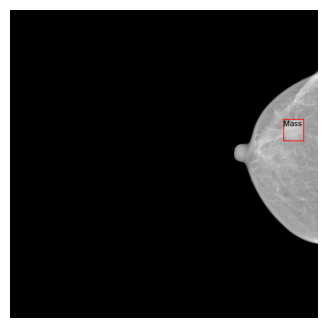

In [37]:
plot_annotations(image.copy(), annotations, id2label)


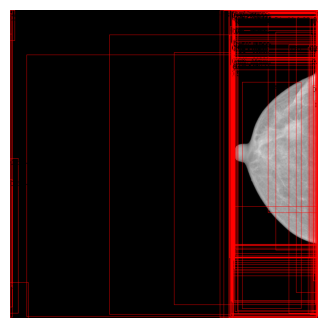

In [38]:
plot_results(image.copy(), predictions, id2label)